In [1]:
import json
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from data_processing import dataSet, numeric_plots
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, BaggingRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from catboost import CatBoostRegressor
import xgboost as xgb

In [2]:
sns.set()
sns.set(rc={'figure.figsize':(8,8)})
sns.set_palette('bright')

In [3]:
RANDOM_SEED = 42

# 2. Машинное обучение.

В этом ноутбуке опробованы различные алгоритмы машинного обучения и проведено сравнение результатов. Рассмотрены алгоритмы:
* OLS-регрессия (красиво взрывается)
* RIDGE-регрессия
* Бэггинг над RIDGE-регрессией
* K ближайших соседей
* Random Forest
* XGBoost
* CatBoost

Почти для всех алгоритмов на кросс-валидации подобраны некоторые гиперпараметры.

В разделе 2.2. применено ансамблирование получившихся алгоритмов (наивное усреднение и стэкинг), как всех сразу, так и только топ-3 по результатам метрики.

Осторожно: довольно требовательно к ресурсам компьютера! Датасет большой, плюс некоторые моменты сделаны неоптимально, например иногда заново фитим алгоритмы на тех же данных. В виду сжатых  сроков полировка и оптимизация некоторых кусков не проводилась. Полный прогон ноутбука на core i5 9го поколения занимает ночь и требует 32 гБ оперативной памяти.

## 2.0. Подготовка данных.

Для начала загрузим и обработаем данные (при помощи написанного при EDA класса) и отделим от трейна отложенную выборку. Также переставим столбцы в тесте для кэггла в том же порядке, в каком они идут в основных данных.

In [4]:
dropcols = ['date_posted', 'views_total', 
            'views_today', 'url', 'catalog_link', 
            'orig_url', 'vin', 'license_plate']
dummy_cols = ['brand', 'model', 'generation', 
              'body_type', 'color', 'fuel_type', 
              'transmission', 'drive', 'wheel', 
              'state', 'pts', 'customs', 'exchange']
test_set = dataSet.from_csv('./input/test_scraped.csv', is_test = True)
test_no_dummies = test_set.prepare_frame_no_dummies(orig_test_path = './input/test.csv')
test_with_dummies = test_set.prepare_frame_with_dummies(dummy_cols)

train_set = dataSet.from_csv('./input/dataset_with_electro.csv', is_test= False)
train_no_dummies = train_set.prepare_frame_no_dummies(
                    test_no_dummies.brand.unique(),
                    test_no_dummies.model.unique())
train_with_dummies = train_set.prepare_frame_with_dummies(dummy_cols)

train_with_dummies, test_with_dummies = dataSet.equalize_columns(train_with_dummies, 
                                                                 test_with_dummies)

train_no_dummies.drop(columns = dropcols, inplace = True)
test_no_dummies.drop(columns = dropcols, inplace = True)
train_with_dummies.drop(columns = dropcols, inplace = True)
test_with_dummies.drop(columns = dropcols, inplace = True)

train_no_dummies.set_index('offer_id', inplace=True)
train_with_dummies.set_index('offer_id', inplace=True)
test_no_dummies.set_index('offer_id', inplace=True)
test_with_dummies.set_index('offer_id', inplace=True)

/home/rivfader/anaconda3/envs/autoru/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
            train_with_dummies.drop(columns = ['log_price']), 
            train_with_dummies.log_price, test_size = 0.3)
kaggle_test = test_with_dummies.drop(columns=['log_price'])[X_test.columns]
X_full, y_full = train_with_dummies.drop(columns = ['log_price']), train_with_dummies.log_price

In [6]:
def make_submission(clf, filename, inflation_factor = 1):
    '''Автоматически делаем предсказине обученной моделью по выборке 
    для кэггла и записываем в файл. Предикт умножаем на inflation_factor, 
    чтобы скомпенсировать инфляцию за период времени, прошедший от сбора цен проверочной
    выборки с кэггла и от сбора обучающих данных.
    '''
    y_pred = clf.predict(kaggle_test)
    sub = pd.concat([pd.Series(test_with_dummies.index).apply(lambda x: str(x)[:-2]),
                     pd.Series(inflation_factor*np.exp(y_pred))], axis=1).rename(
                                columns = {'offer_id':'sell_id', 0:'price'})
    sub.to_csv(filename, index=False)

In [7]:
def mapes(y_true, y_pred):
    '''
    Печатаем MAPE для логарифма цены и для цены в рублях, возвращаем эти значения
    для сохранения в словаре с результатами.
    '''
    mape_log = mape(y_true, y_pred)
    mape_rub = mape(np.exp(y_true), np.exp(y_pred))
    print(f'MAPE для логарифма цены: {mape_log}')
    print(f'MAPE для цены в рублях: {mape_rub}')
    return mape_log, mape_rub 

results = {}

## 2.1. Эксперименты над отдельными алгоритмами.
### 2.1.0. Простая линейная регрессия

Попробуем простейший метод линейной регресии. Ничего хорошего не ждём, у нас есть коррелирующие столбцы в матрице плана.

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [9]:
mape(y_test, y_pred)

0.011241794894786647

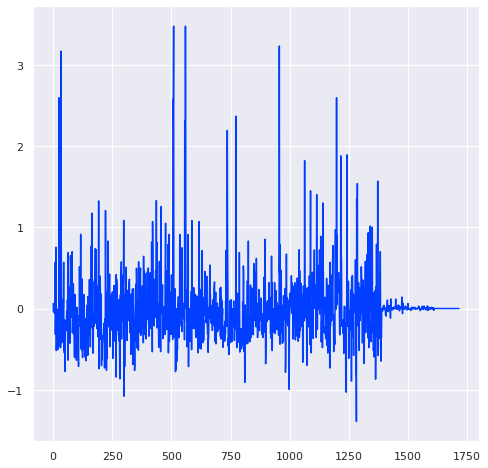

In [10]:
plt.plot(lr.coef_)

Линейная регрессия взорвалась. Прикольно. Это потому что матрица $X^T X$ очевидно близка к необратимой. Выкинем объём двигателя.

In [11]:
lr = LinearRegression()
lr.fit(X_train.drop(columns=['engine_volume']), y_train)
y_pred = lr.predict(X_test.drop(columns=['engine_volume']))

In [12]:
mape(y_test, y_pred)

0.011245362516111022

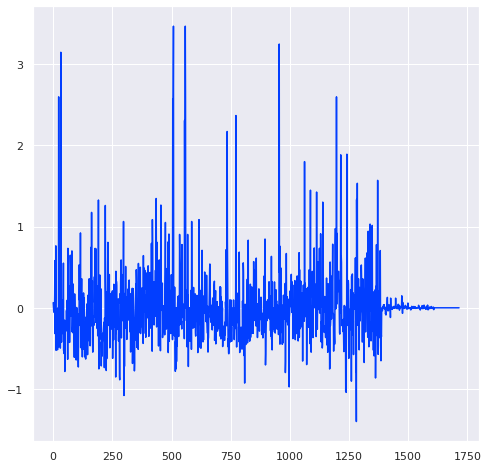

In [13]:
plt.plot(lr.coef_)

Не особо помогает. Видимо, мультиколлинеарности там много. Регуляризация!

### 2.1.1. RIDGE regression

In [14]:
ridge = Ridge(random_state=RANDOM_SEED)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
results["Ridge_basic"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.011271474945185937
MAPE для цены в рублях: 0.15109988360463422


Ну вот, другое дело. Потюним гиперпараметры.

In [15]:
search_grid_lr = {
    'alpha':[0.5, 1, 2, 4, 6],
    'max_iter': [100, 1000, 10000],
}
gridsearch_lr = GridSearchCV(estimator = ridge, 
                             param_grid = search_grid_lr, 
                             scoring='neg_mean_absolute_percentage_error', 
                             n_jobs=-1, 
                             verbose = 2)
gridsearch_lr.fit(X_train, y_train)
best_lr = gridsearch_lr.best_estimator_
print(best_lr)
best_lr.fit(X_train, y_train)
y_pred = best_lr.predict(X_test)
results["Ridge_tuned"] = mapes(y_test, y_pred)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Ridge(alpha=0.5, max_iter=100, random_state=42)
MAPE для логарифма цены: 0.011250854711107316
MAPE для цены в рублях: 0.150747576169629


In [16]:
best_lr.fit(X_full, y_full)
make_submission(best_lr, './output/best_ridge_no_correction.csv')

Результат на кэгле - 17.76. Либо переобучение, либо инфляция (обучающий датасет на полгода старше тренировочного).
Для улучшения MAPE на кэггловсокй выборке придётся модифицировать либо обучающую выборку (уменьшать цены в ней на несколько процентов), либо предикт (уменьшать его на несколько процентов). По-хорошему нужно найти статистику по изменению цен на конкретные модели автомобилей, чтобы изменять не всю выборку разом, а отдельно для каждой модели. Но такой статистики в удобоваримом виде найти не удалось.
Эксперименты показали, что достаточно модифицировать предикт. Уменьшение на 9% улучшает MAPE на несколько единиц.

In [17]:
make_submission(best_lr, './output/best_ridge_correction.csv', 0.91)

Сразу стало 14.74. Интересно попробовать бэггинг.

In [18]:
bagger_lr = BaggingRegressor(base_estimator=best_lr, random_state=RANDOM_SEED, n_estimators=20)
bagger_lr.fit(X_train, y_train)
y_pred = bagger_lr.predict(X_test)
results["ridge_bagging"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.011261242374277154
MAPE для цены в рублях: 0.15086757244776716


Поробовали, если трогать другие параметры (max_samples, max_features), то становится только хуже.

In [19]:
bagger_lr.fit(X_full, y_full)
make_submission(bagger_lr, './output/bagger_lr_correction.csv', 0.91)

### 2.1.2. K ближайших соседей.

Несмотря на то, что knn в основном ииспользуется для классификации, регрессор на этом алгоритме тоже есть. Попробуем.

In [20]:
knr = KNeighborsRegressor(n_neighbors=3)
knr.fit(X_train, y_train)
y_pred = knr.predict(X_test)
results["KNNR_basic"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.014410609896361339
MAPE для цены в рублях: 0.19290145177806334


К ближайших соседей не очень хорошо себя показал, и очень меделнно работает. Попытка потюнить гиперпараметры не удалась - ОЧЕНЬ долго считается. Тем не менее, попробуем включить его в стекинг.

In [21]:
knr.fit(X_full, y_full)
make_submission(knr, './output/knr_no_correction.csv')
make_submission(knr, './output/knr_correction.csv', 0.91)

### 2.1.3. Random Forest.

In [22]:
rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs=-1, verbose = False)

In [23]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [24]:
results["random_forest_basic"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.010828005246123948
MAPE для цены в рублях: 0.14481417285079315


<AxesSubplot:>

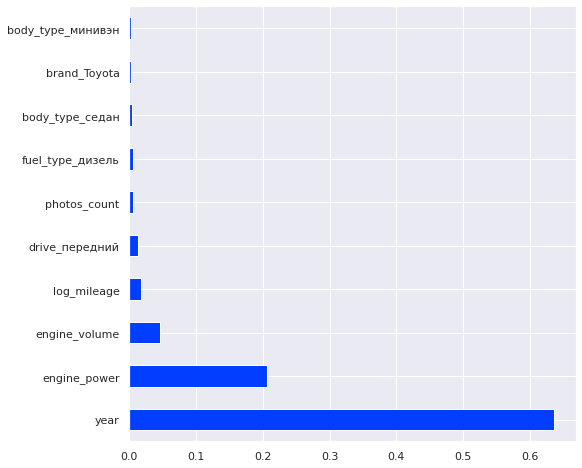

In [25]:
(pd.Series(rf.feature_importances_, index = X_train.columns)
     .sort_values(ascending = False)
     .iloc[0:10].plot(kind = 'barh'))

In [26]:
rf.fit(X_full, y_full)
make_submission(rf, './output/random_forest_no_correction.csv')
make_submission(rf, './output/random_forest_correction.csv', 0.91)

In [27]:
search_grid_rf = {
    'n_estimators':[100, 200],
    'max_depth': [None, 100],
}
gridsearch = GridSearchCV(estimator = rf, 
                          param_grid = search_grid_rf, 
                          scoring='neg_mean_absolute_percentage_error', 
                          n_jobs=-1, verbose = 3)
gridsearch.fit(X_train, y_train)
best_rf = gridsearch.best_estimator_
print(best_rf)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
results["random_forest_tuned"] = mapes(y_test, y_pred)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42,
                      verbose=False)
MAPE для логарифма цены: 0.010782219299221135
MAPE для цены в рублях: 0.14411621477548026


In [28]:
del rf

Random Forest лучше ридж-регресии, но не драматически (не в разы).

In [29]:
best_rf.fit(X_full, y_full)
make_submission(best_rf, './output/best_rf_no_correction.csv')
make_submission(best_rf, './output/best_rf_correction.csv', 0.91)

### 2.1.4. XGBOOST

In [30]:
xgbr = xgb.XGBRegressor(verbosity=1, random_state=RANDOM_SEED)

In [31]:
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)
results["xgboost_basic"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.011537180732177651
MAPE для цены в рублях: 0.15538096531753878


In [32]:
xgbr.fit(X_full, y_full)
make_submission(xgbr, './output/xgb_no_correction.csv')
make_submission(xgbr, './output/xgb_correction.csv', 0.91)

In [33]:
xgb_param_grid =  {
        'learning_rate' : [0.1, 0.3] ,
        'min_child_weight' : [ 1, 3]}
    
gridsearch_xgb = GridSearchCV(estimator = xgbr, 
                              param_grid = xgb_param_grid, 
                              scoring='neg_mean_absolute_percentage_error', 
                              n_jobs=-1)

In [34]:
gridsearch_xgb.fit(X_train, y_train)
best_xgb = gridsearch_xgb.best_estimator_
print(best_xgb)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
results["xgboost_tuned"] = mapes(y_test, y_pred)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)
MAPE для логарифма цены: 0.011519535306493647
MAPE для цены в рублях: 0.1551910277622326


In [35]:
del xgbr

In [36]:
best_xgb.fit(X_full, y_full)
make_submission(best_xgb, './output/best_xgb_no_correction.csv')
make_submission(best_xgb, './output/best_xgb_correction.csv', 0.91)

Результаты не впечатляют, хуже регрессии. Но это, возможно, от некорректного подбора гиперапараметров.

### 2.1.5. CatBoost.

In [37]:
cr = CatBoostRegressor(logging_level = 'Silent', 
                       task_type="CPU", 
                       random_seed=RANDOM_SEED)
cr.fit(X_train, y_train)
y_pred = cr.predict(X_test)
results["catboost_basic"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.010837071144234909
MAPE для цены в рублях: 0.14521982711781162


In [38]:
cr.fit(X_full, y_full)
make_submission(cr, './output/catboost_no_correction.csv')
make_submission(cr, './output/catboost_correction.csv', 0.91)

In [39]:
cr_params =  {"iterations": [1000, 2000],
              "depth": [4,8]}
gridsearch_cat = GridSearchCV(estimator = cr, param_grid = cr_params, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
gridsearch_cat.fit(X_train, y_train)
best_cat = gridsearch_cat.best_estimator_
print(best_cat.get_params())

{'iterations': 2000, 'depth': 8, 'loss_function': 'RMSE', 'random_seed': 42, 'logging_level': 'Silent', 'task_type': 'CPU'}


In [40]:
del cr

In [41]:
best_cat.fit(X_train, y_train)
y_pred = best_cat.predict(X_test)
results["catboost_tuned"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.01045811502590398
MAPE для цены в рублях: 0.14000614211509696


In [42]:
best_cat.fit(X_full, y_full)
make_submission(best_cat, './output/best_cat_no_correction.csv')
make_submission(best_cat, './output/best_cat_correction.csv', 0.91)

Подбор гиперпараметров позволил улучшить метрику.

### 2.1.6. Деревья (и бэггинг над ними как в random forest)

Сначала попробуем просто дерево. Ожидается переобучение.

In [43]:
treereg = DecisionTreeRegressor(random_state=RANDOM_SEED)
treereg.fit(X_train, y_train)
y_pred = treereg.predict(X_test)
results["tree_basic"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.015165222673475311
MAPE для цены в рублях: 0.21133139377258925


<AxesSubplot:>

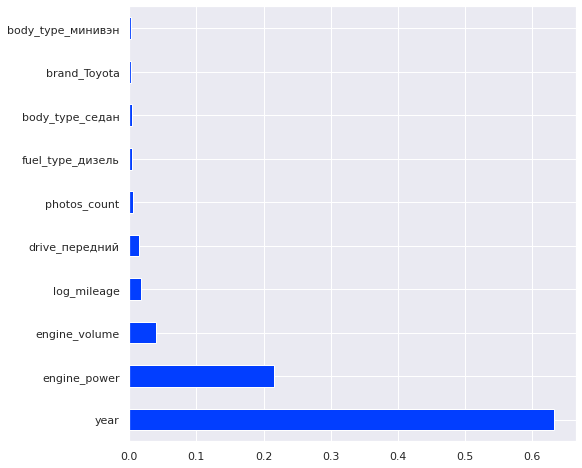

In [44]:
(pd.Series(treereg.feature_importances_, index = X_train.columns)
     .sort_values(ascending = False)
     .iloc[0:10].plot(kind = 'barh'))

In [45]:
tree_params =  {'max_features': ['auto', 'sqrt', 'log2'],
               'min_samples_split': [5, 10, 25, 50, 75, 100, 200],
               'max_depth': [10,20,50]}
gridsearch_tree = GridSearchCV(estimator = treereg, param_grid = tree_params, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
gridsearch_tree.fit(X_train, y_train)
best_tree = gridsearch_tree.best_estimator_
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)
print(best_tree)
results["tree_tuned"] = mapes(y_test, y_pred)

DecisionTreeRegressor(max_depth=20, max_features='auto', min_samples_split=50,
                      random_state=42)
MAPE для логарифма цены: 0.012408429087294394
MAPE для цены в рублях: 0.16858340320229614


In [46]:
bagger_tree = BaggingRegressor(base_estimator=best_tree)
bagger_tree.fit(X_train, y_train)
y_pred = bagger_tree.predict(X_test)
results["tree_bagging"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.011292751354508553
MAPE для цены в рублях: 0.15167706416182972


In [47]:
bag_params =  {'n_estimators': [10, 50, 100],
              'max_samples': [0.5, 0.75, 1.0],
               'max_features': [0.5, 0.75, 1.0]}
gridsearch_bag = GridSearchCV(estimator = bagger_tree, param_grid = bag_params, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
gridsearch_bag.fit(X_train, y_train)
best_bag_tree = gridsearch_bag.best_estimator_
best_bag_tree.fit(X_train, y_train)
y_pred = best_bag_tree.predict(X_test)
print(best_bag_tree)
results["tree_bagging_tuned"] = mapes(y_test, y_pred)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=20,
                                                      max_features='auto',
                                                      min_samples_split=50,
                                                      random_state=42),
                 max_features=0.75, max_samples=0.75, n_estimators=100)
MAPE для логарифма цены: 0.01127395088906761
MAPE для цены в рублях: 0.15330747651435597


Бэггинг улучшает работу дерева, впрочем это получается аналог random forest.

### 2.1.7. Результаты.

In [48]:
print(results)

{'Ridge_basic': (0.011271474945185937, 0.15109988360463422), 'Ridge_tuned': (0.011250854711107316, 0.150747576169629), 'ridge_bagging': (0.011261242374277154, 0.15086757244776716), 'KNNR_basic': (0.014410609896361339, 0.19290145177806334), 'random_forest_basic': (0.010828005246123948, 0.14481417285079315), 'random_forest_tuned': (0.010782219299221135, 0.14411621477548026), 'xgboost_basic': (0.011537180732177651, 0.15538096531753878), 'xgboost_tuned': (0.011519535306493647, 0.1551910277622326), 'catboost_basic': (0.010837071144234909, 0.14521982711781162), 'catboost_tuned': (0.01045811502590398, 0.14000614211509696), 'tree_basic': (0.015165222673475311, 0.21133139377258925), 'tree_tuned': (0.012408429087294394, 0.16858340320229614), 'tree_bagging': (0.011292751354508553, 0.15167706416182972), 'tree_bagging_tuned': (0.01127395088906761, 0.15330747651435597)}


Наши чемпионы - CatBoost, бэггинг над линейной регрессией и random forest.

## 2.2. Ансамблирование.

### 2.2.0. Наивное усреднение

Просто усредним предсказания моделей.

In [49]:
class AverageModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [50]:
aver = AverageModel([best_lr, bagger_lr, knr, best_rf, best_xgb, best_cat, best_tree, best_bag_tree])

In [51]:
aver.fit(X_train, y_train)
y_pred = aver.predict(X_test)
results["average_all"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.010394450944264841
MAPE для цены в рублях: 0.1385614412472815


In [52]:
aver.fit(X_full, y_full)
make_submission(aver, './output/aver_no_correction.csv')
make_submission(aver, './output/aver_correction.csv', 0.91)

Даже простенькое усреднение очень хорошо себя показывает по метрике.

### 2.2.2. Stacking

Попробуем подобрать мета-алгоритм для ансамбля из всех моделей с подобранными гиперпараметрами, а потом применим его к ансамблю из топ-3 алгоритмов по MAPE. 
Расчёт занимает несколько часов. Его наверняка можно оптимизировать, но в виду сжатых сроков он просто оставлен на ночь.

In [53]:
best_lr = Ridge(alpha=0.5, 
                max_iter=100, 
                random_state=RANDOM_SEED)

bagger_lr = BaggingRegressor(base_estimator=best_lr, 
                             random_state=RANDOM_SEED, 
                             n_estimators=20)

knr = KNeighborsRegressor(n_neighbors=3)

best_rf = RandomForestRegressor(n_estimators=200,
                                n_jobs=-1, 
                                random_state=RANDOM_SEED,
                                verbose=False)

best_xgb = xgb.XGBRegressor(verbosity=1, 
                            random_state=RANDOM_SEED,
                            learning_rate=0.3,
                            n_estimators=100,
                            max_depth=6)

best_cat = CatBoostRegressor(logging_level = 'Silent', 
                             task_type="CPU", 
                             random_seed=RANDOM_SEED,
                             iterations = 2000,
                             depth = 8)
best_tree = DecisionTreeRegressor(max_depth=20, 
                                  max_features='auto', 
                                  min_samples_split=50,
                                  random_state=RANDOM_SEED)

best_bag_tree = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=20,
                                                      max_features='auto',
                                                      min_samples_split=50,
                                                      random_state=RANDOM_SEED),
                                                      max_features=0.75, 
                                                      n_estimators=100)

In [54]:
estimators = [('Ridge', best_lr),
              ('Bag_lr', bagger_lr),
              ('knr', knr),
              ('Random Forest', best_rf),
              ('XGB', best_xgb),
              ('CatBoost', best_cat),
              ('best_tree', best_tree),
              ('best_bag_tree', best_bag_tree)
             ]
estimators_champions = [
              ('Bag_lr', bagger_lr),
              ('Random Forest', best_rf),
              ('CatBoost', best_cat),
             ]
final_estimators = [('Ridge', Ridge(random_state=RANDOM_SEED)),
                    ('Random Forest', RandomForestRegressor(random_state=RANDOM_SEED)),
                    ('XGB', xgb.XGBRegressor(random_state=RANDOM_SEED)),
                    ('Catboost', CatBoostRegressor(random_state=RANDOM_SEED)),
                   ]

In [ ]:
stacks_1_layer = [(est[0], StackingRegressor(estimators = estimators, 
                                             final_estimator=est[1], 
                                             verbose = False)) 
                  for est in final_estimators]
predicts = []
for stack in stacks_1_layer:
    stack[1].fit(X_train, y_train)
    y_pred = stack[1].predict(X_test)
    predicts.append((stack[0], y_pred))

In [56]:
for pred in predicts:
    print('**************')
    print(pred[0])
    mapes(y_test, pred[1])
    print('**************')

**************
Ridge
MAPE для логарифма цены: 0.010163345389872425
MAPE для цены в рублях: 0.13544476056864016
**************
**************
Random Forest
MAPE для логарифма цены: 0.010409506954823863
MAPE для цены в рублях: 0.13921560183385223
**************
**************
XGB
MAPE для логарифма цены: 0.010423771040459462
MAPE для цены в рублях: 0.1393901746088001
**************
**************
Catboost
MAPE для логарифма цены: 0.010284619443653708
MAPE для цены в рублях: 0.13754600601758862
**************


В любом случае стэкинг явно даёт эффект, и простая ридж-регрессия в качестве мета-алгоритма справляется лучше всех.

In [57]:
del stacks_1_layer
best_stack = StackingRegressor(estimators = estimators, 
                              final_estimator=Ridge(random_state=RANDOM_SEED), 
                              verbose = False)

In [58]:
final_estimator=Ridge(random_state=RANDOM_SEED)
best_stack.fit(X_full, y_full)
make_submission(best_stack, './output/stacking_no_correction.csv')
make_submission(best_stack, './output/stacking_correction.csv', 0.91)

Теперь попробуем на топ-3 алгоритмах.

In [59]:
best_stack_champions = StackingRegressor(estimators = estimators_champions, 
                              final_estimator=Ridge(random_state=RANDOM_SEED), 
                              verbose = False)
best_stack_champions.fit(X_train, y_train)
y_pred = best_stack_champions.predict(X_test)
mapes(y_test, y_pred)

MAPE для логарифма цены: 0.010183168881483087
MAPE для цены в рублях: 0.1357174868140912


(0.010183168881483087, 0.1357174868140912)

По результатам валидации на обучющей выборке прирост хороший, по результатам проверки на кэггле похуже, но всё равно это лучший результат.

In [60]:
best_stack_champions.fit(X_full, y_full)
make_submission(best_stack_champions, './output/stacking_champions.csv', 0.91)
make_submission(best_stack_champions, './output/stacking_champions_no_correction.csv')

# 3. Выводы.

1. Отмечен эффект разницы во времени сбора тестовой и обучающей выборки. Целевая переменная (цена) в тестовой выборке отстаёт по времени от обучающей, поэтому метрика на валидации получается лучше, чем на тесте. В данном случае это исправляется простой поправкой на инфляцию, но не всегда может быть всё так просто.
2. Проверены одиночные алгоритмы машинного обучения. По результатам можно сказать, что не всегда сложные алгоритмы типа XGBoost дают результат лучше, чем простая ридж-регрессия. Но это, возможно, связано с тем, что эти алгоритмы требуют более сложной настройки и осознанного подбора многих гиперпараметров.
3. Использование нескольких алгоритмов в ансамбле даёт определённый прирост метрики, как в случае простого усреднения, так и в случае стэкинга.